# Compaction model

This notebook uses modules from SnowModel's Snowpack numerical model (2006), re-written in Fortran 95. We tried to compile the codes directly here, but as it proves complicated, we simply compile them in a terminal window and directly call the modules here.

In [1]:
from numpy import f2py
import matplotlib.pyplot as plt

In [2]:
# with open('ddensity_ml.f95') as sourcefile:
    # sourcecode = sourcefile.read()
# f2py.compile(sourcecode, modulename='ddensity')

## Testing the density code

In [3]:
import ddensity

In [4]:
print(ddensity.ddensity_ml.__doc__)

ro_layer_out,dy_snow_out = ddensity_ml(ro_layer,tf,dt,ro_water,ro_ice,t_old,jj,dy_snow,a1,a2,[nz_max])

Wrapper for ``ddensity_ml``.

Parameters
----------
ro_layer : input rank-1 array('f') with bounds (nz_max)
tf : input float
dt : input float
ro_water : input float
ro_ice : input float
t_old : input rank-1 array('f') with bounds (nz_max)
jj : input int
dy_snow : input rank-1 array('f') with bounds (nz_max)
a1 : input float
a2 : input float

Other Parameters
----------------
nz_max : input int, optional
    Default: shape(ro_layer, 0)

Returns
-------
ro_layer_out : rank-1 array('f') with bounds (nz_max)
dy_snow_out : rank-1 array('f') with bounds (nz_max)



In [5]:
ro_layer = [1, 1]
t_old = [-7, -5]
dy_snow = [3, 4]
ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, 0, 1, 2, 1.5, t_old, 2, dy_snow, 0.0013, 0.021)

In [6]:
print(ro_layer, t_old, dy_snow)

[1.0019996 1.0008533] [-7, -5] [2.994013  3.9965897]


## Testing the temperature code

In [7]:
import snowtemp

In [8]:
print(snowtemp.snowtemp_ml.__doc__)

t_new = snowtemp_ml(gamma,t_old,tsfc,jj,dt,ro_layer,cp_snow,tf,dy_snow,melt_flag,[nz_max])

Wrapper for ``snowtemp_ml``.

Parameters
----------
gamma : input rank-1 array('f') with bounds (nz_max)
t_old : input rank-1 array('f') with bounds (nz_max)
tsfc : input float
jj : input int
dt : input float
ro_layer : input rank-1 array('f') with bounds (nz_max)
cp_snow : input float
tf : input float
dy_snow : input rank-1 array('f') with bounds (nz_max)
melt_flag : input rank-1 array('i') with bounds (nz_max)

Other Parameters
----------------
nz_max : input int, optional
    Default: shape(gamma, 0)

Returns
-------
t_new : rank-1 array('f') with bounds (nz_max)



In [9]:
gamma = [0, 0, 0]   # TODO get rid of this argument in inputs
t_old = [-6, -8, -19]
ro_layer = [1.2, 1.1, 1]
dy_snow = [2, 3, 8]
melt_flag = [0, 0, 0]
t_new = snowtemp.snowtemp_ml(gamma, t_old, -25, 3, 1000, ro_layer, 2.1, 0, dy_snow, melt_flag)

In [10]:
print(t_new)

[ -9.094132 -10.769745 -19.002752]


## Combining both models

In [17]:
# Initial state with 3 layers

ro_layer = [100, 100, 100]
tf = 0
dt = 100
ro_water = 1000
ro_ice = 910
t_old = [-5, -5, -5]
jj = 3
dy_snow = [5, 5, 5]
a1 = 0.0013
a2 = 0.021
gamma = [0, 0, 0]
tsfc = -25
cp_snow = 2.1
melt_flag = [0, 0, 0]

In [18]:
# Initialize arrays to keep track of variables in time

ro_layer_evolution = [ro_layer]
depth_evolution = [dy_snow]
temperature_evolution = [t_old]

In [19]:
# Update variables at each timepoint

for i in range(1000):
    ro_layer, dy_snow = ddensity.ddensity_ml(ro_layer, tf, dt, ro_water, 
                                         ro_ice, t_old, jj, dy_snow, a1, a2)
    t_old = snowtemp.snowtemp_ml(gamma, t_old, tsfc, jj, dt, ro_layer, cp_snow, 
                                 tf, dy_snow, melt_flag)
    ro_layer_evolution.append(ro_layer)
    depth_evolution.append(dy_snow)
    temperature_evolution.append(t_old)

## Plot evolution of variables in time

Text(0, 0.5, 'Density')

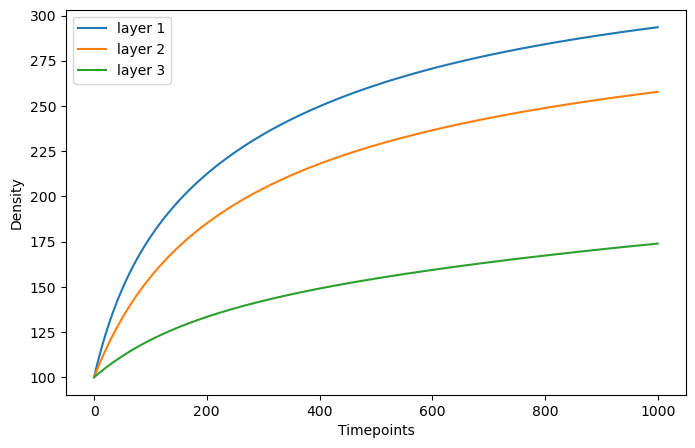

In [20]:
# Density

layer1 = [ro_layer_evolution[i][0] for i in range(len(ro_layer_evolution))]
layer2 = [ro_layer_evolution[i][1] for i in range(len(ro_layer_evolution))]
layer3 = [ro_layer_evolution[i][2] for i in range(len(ro_layer_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1')    # TODO specify if it's the top, middle or bottom layer
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Density')

Text(0, 0.5, 'Depth')

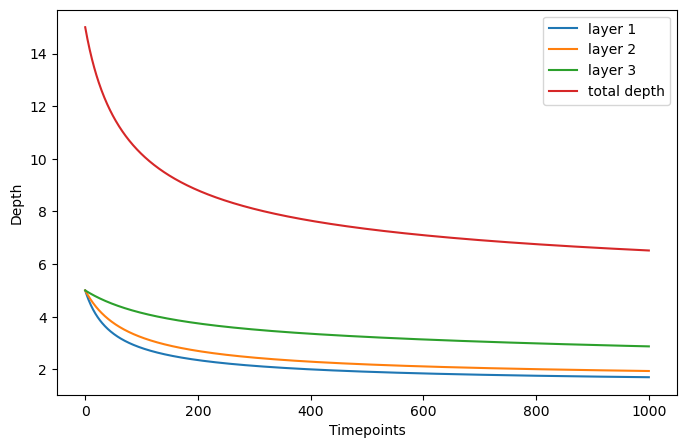

In [21]:
# Depth

layer1 = [depth_evolution[i][0] for i in range(len(depth_evolution))]
layer2 = [depth_evolution[i][1] for i in range(len(depth_evolution))]
layer3 = [depth_evolution[i][2] for i in range(len(depth_evolution))]
sum_layers = [layer1[i] + layer2[i] + layer3[i] for i in range(len(depth_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1')    # TODO specify if it's the top, middle or bottom layer
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.plot(sum_layers, label='total depth')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Depth')

Text(0, 0.5, 'Temperature')

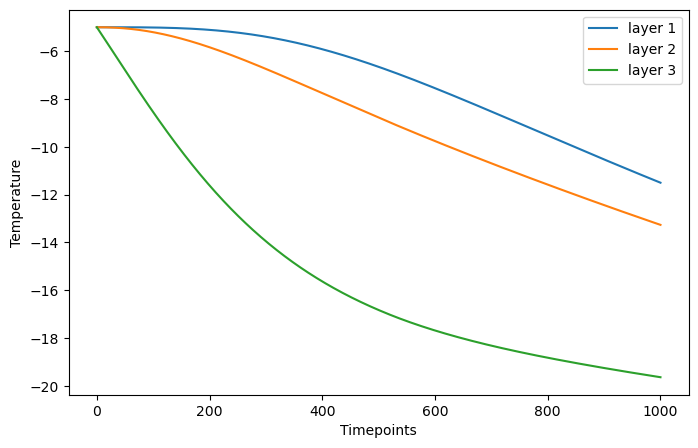

In [22]:
# Temperature

layer1 = [temperature_evolution[i][0] for i in range(len(temperature_evolution))]
layer2 = [temperature_evolution[i][1] for i in range(len(temperature_evolution))]
layer3 = [temperature_evolution[i][2] for i in range(len(temperature_evolution))]

plt.figure(figsize=(8, 5))
plt.plot(layer1, label='layer 1')    # TODO specify if it's the top, middle or bottom layer
plt.plot(layer2, label='layer 2')
plt.plot(layer3, label='layer 3')
plt.legend()
plt.xlabel('Timepoints')
plt.ylabel('Temperature')